## Lista 1 - Disciplina IA006 - Exercícios de Fixação 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
fname = '../data/sunspot.txt'
data = np.loadtxt(fname)

In [86]:
class MyData():
    def __init__(self, array):
        self.years = array[:, 0].copy()
        self.sunspot = array[:, 1:].copy()
        
        # create 20 features which are delays of the original data
        # and remove rows that contains zeros as input features
        flat_sunspot = self.sunspot.flatten()
        data = np.zeros( (flat_sunspot.shape[0], 21) )
        data[:,-1] = flat_sunspot
        for i in range(20):
            data[(i+1):, i] = flat_sunspot[:-(i+1)]
        self.data = data[20:] #drop first 20 lines because of zero'd features
        
        self.features = self.data[:, :-1]
        self.label = self.data[:, -1]
        self.nfeatures = self.features.shape[1]
        self.nrows = self.features.shape[0]
        
    def split_kfold(self, k, nktest):
        assert (nktest < k), "Fold selected for test must be within number of K-folds"
        
        nrows = self.nrows
        nelements = np.ceil(nrows/k)
        
        mask = np.array([ True if ((i >= nelements*nktest) and (i < nelements*(nktest+1))) 
                         else False 
                         for i in range(nrows)],
                        dtype='bool')

        return mask
        

In [64]:
class LinearRegressor():
    def __init__(self):
        self.w = None
        self.nfeatures = None
        
    def fit(self, features, label, reg=0):
        assert (reg >= 0), "Regularization should be non-negative number."
        
        self.nfeatures = features.shape[1]
        nlines = features.shape[0]
        # first column will be the constant bias
        fea = np.hstack( ( np.ones((nlines,1)), features ) )       
        
        if reg == 0:
            self.w = np.linalg.inv( fea.T @ fea ) @ fea.T @ label
        if reg  > 0:
            pseudo_eye = np.eye(fea.shape[1])
            pseudo_eye[0, 0] = 0
            self.w = np.linalg.inv( (fea.T @ fea) + (pseudo_eye * reg) ) @ fea.T @ label
        return self
    
    def transform(self, x):
        assert (self.w is not None), "Transformer was not trained yet."
        assert (x.shape[1] == self.nfeatures), "Input error: wrong number of columns"
        
        if (x.shape[1] == self.nfeatures + 1):
            # assuming last column contains label
            x_ = x[:, :-1]
        else:
            x_ = x
            
        fea = np.zeros( (x_.shape[0], x_.shape[1] + 1) )
        fea[:, 0] = 1
        fea[:, 1:] = x_
        return fea @ self.w

In [65]:
class BoolMask():
    def __init__(self, nfeatures=20, mask=None):
        self.initialize(nfeatures, mask)
    
    def initialize(self, nfeatures=20, mask=None):
        if ((mask is not None) and (nfeatures == mask.shape[0])):
            self.mask = mask.copy()
        else:
            self.mask = np.ones(nfeatures, dtype='bool')
        
    def remove(self, feature):
        self.mask[feature] = False
    
    def insert(self, feature):
        self.mask[feature] = True
        
    def save(self):
        r = BoolMask(mask=self.mask)
        return r


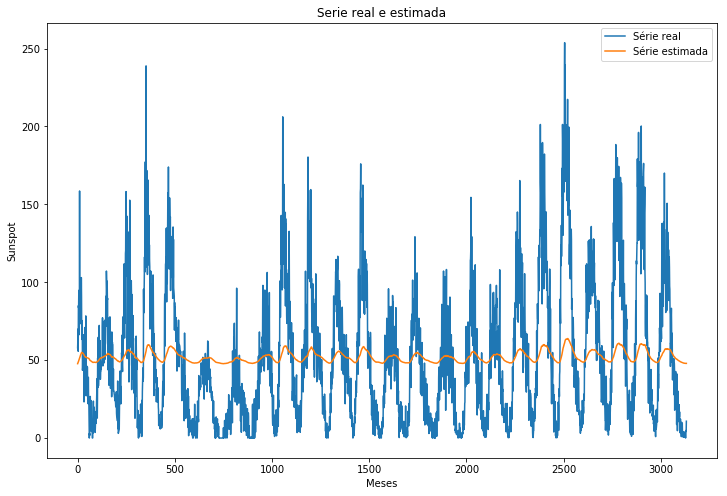

In [66]:
## Auxiliar functions

def plot_realvsprediction(y_real, y_prediction, title=None):
    plt.plot(y_real, label='Série real')
    plt.plot(y_prediction, label='Série estimada')

    plt.legend()
    plt.xlabel('Meses')
    plt.ylabel('Sunspot')
    if (title != None):
        plt.title(title)
    
    plt.show()
    return

def rmse(y_real, y_pred):
    e = np.sqrt(np.mean(np.square(y_real - y_pred)))
    print('Erro quadrático médio do modelo: ', e)
    return e

plot_realvsprediction(y_real, y_predict, 'Serie real e estimada')

In [87]:
dt = MyData(data)

In [68]:
def unit_test():
    model = LinearRegressor()
    model.fit(dt.features, dt.training_label)
    y_predict = model.transform(dt.training_features)
    y_real = dt.training_label
    mse = np.mean(np.power(y_real - y_predict, 2))
    print(int(mse) == 239)
    assert(int(mse) == 239)
unit_test()

AttributeError: 'MyData' object has no attribute 'training_features'

In [62]:
model = LinearRegressor()
model.fit(dt.training_features, dt.training_label, reg=1000000000)
y_predict = model.transform(dt.training_features)
y_real = dt.training_label
print(rmse(y_real, y_predict))
print(model.w)

Erro quadrático médio do modelo:  41.57693772126353
41.57693772126353
[4.77346099e+01 5.28461879e-03 5.08702576e-03 4.98946411e-03
 4.91412126e-03 4.81889062e-03 4.73361604e-03 4.61722319e-03
 4.53251408e-03 4.47043174e-03 4.35166993e-03 4.21893481e-03
 4.07377051e-03 3.91767856e-03 3.78751351e-03 3.63583015e-03
 3.44271563e-03 3.27232645e-03 3.07601868e-03 2.91441414e-03
 2.73745956e-03]


In [54]:
m = BoolMask()
m.remove(17)
b = m.save()
m.insert(17)
m.mask
b.mask
dt.training_features[:,b.mask].shape

(3132, 19)

In [91]:
def get_kfold_function(data, k):
    def clojure(n):
        return data.split_kfold(k, n)
    return clojure
    
kfs = get_kfold_function(dt,10)

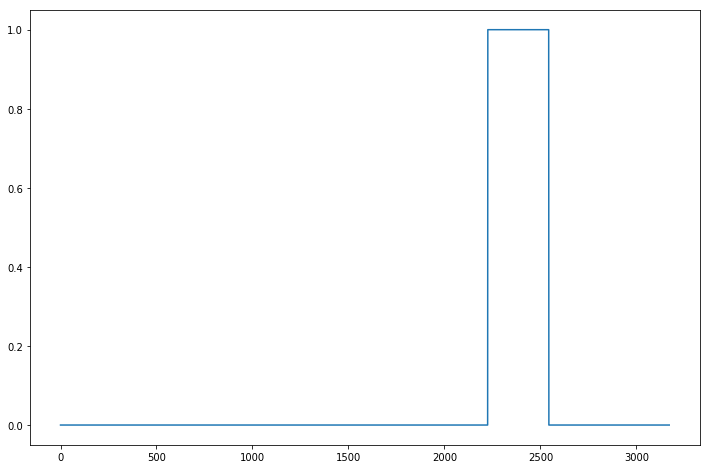

In [96]:
plt.plot(kfs(7))